In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [2]:
df = pd.read_csv("../../dataset/KEY.csv")
# 2. Đọc file csv và gắng index với giá Close
df1=df.reset_index()['Close']

In [3]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [4]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [5]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [6]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [7]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [8]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [9]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100


In [ ]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

2/2 [==============================] - 0s 55ms/step


In [ ]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [ ]:
y_test = scaler.inverse_transform(ytest.reshape(-1,1))
ytest

y_val = scaler.inverse_transform(yval.reshape(-1,1))
yval

array([0.8420127 , 0.8605276 , 0.89912066, 0.90219834, 0.90698583,
       0.92447484, 0.9381534 , 0.94093796, 0.9703957 , 0.93634587,
       0.97391304, 0.97322912, 0.99027846, 0.98544211, 0.9863703 ,
       0.9876893 , 0.99404006, 0.98939912, 0.9975574 , 1.        ,
       0.99369809, 0.99614069, 0.99413776, 0.9803615 , 0.94880313,
       0.94274548, 0.94899853, 0.92183683, 0.93839766, 0.96067416,
       0.9456766 , 0.914851  , 0.91079629, 0.9345872 , 0.91402052,
       0.94523693, 0.93859306, 0.96160234, 0.95486077, 0.95026869,
       0.96443576, 0.96116268, 0.93028823, 0.9284807 , 0.95603322,
       0.96380068, 0.95344406, 0.93820225, 0.95842697, 0.95236932,
       0.9358085 ])

In [ ]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
valid_mae = np.mean(np.abs(y_pred - yval))
test_mae = np.mean(np.abs(y_pred - ytest))
valid_mape = np.mean(np.abs((y_pred - y_val) / y_val)) * 100
test_mape = np.mean(np.abs((y_pred - y_test) / y_test)) * 100
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Validation MAE:', valid_mae)
print('Testing MAPE:', test_mae)
print('Validation MAE:', valid_mape)
print('Testing MAPE:', test_mape)

Validation RMSE: 221.93537363607308
Testing RMSE: 171.45582607449379


In [ ]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, 92, 1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

[0.8992212]
93
[0.8992212]
94
[0.8992212]
95
[0.8992212]
96
[0.8992212]
97
[0.8992212]
98
[0.8992212]
99
[0.8992212]
100
[0.8992212]
101
9 day input [0.83434294 0.84088911 0.83097215 0.8296043  0.84792379 0.84797264
 0.85461651 0.84894968 0.85940401 0.85530044 0.84978017 0.85036639
 0.85002443 0.85842697 0.83786028 0.83160723 0.84499267 0.84958476
 0.84924279 0.87440156 0.87508549 0.87103078 0.89057157 0.89716659
 0.88290181 0.8913532  0.90214949 0.89819248 0.88612604 0.88974108
 0.8666341  0.86765999 0.84005862 0.86956522 0.87606253 0.86565706
 0.85315095 0.86003908 0.84382022 0.8420127  0.8605276  0.89912066
 0.90219834 0.90698583 0.92447484 0.9381534  0.94093796 0.9703957
 0.93634587 0.97391304 0.97322912 0.99027846 0.98544211 0.9863703
 0.9876893  0.99404006 0.98939912 0.9975574  1.         0.99369809
 0.99614069 0.99413776 0.9803615  0.94880313 0.94274548 0.94899853
 0.92183683 0.93839766 0.96067416 0.9456766  0.914851   0.91079629
 0.9345872  0.91402052 0.94523693 0.93859306 0.96

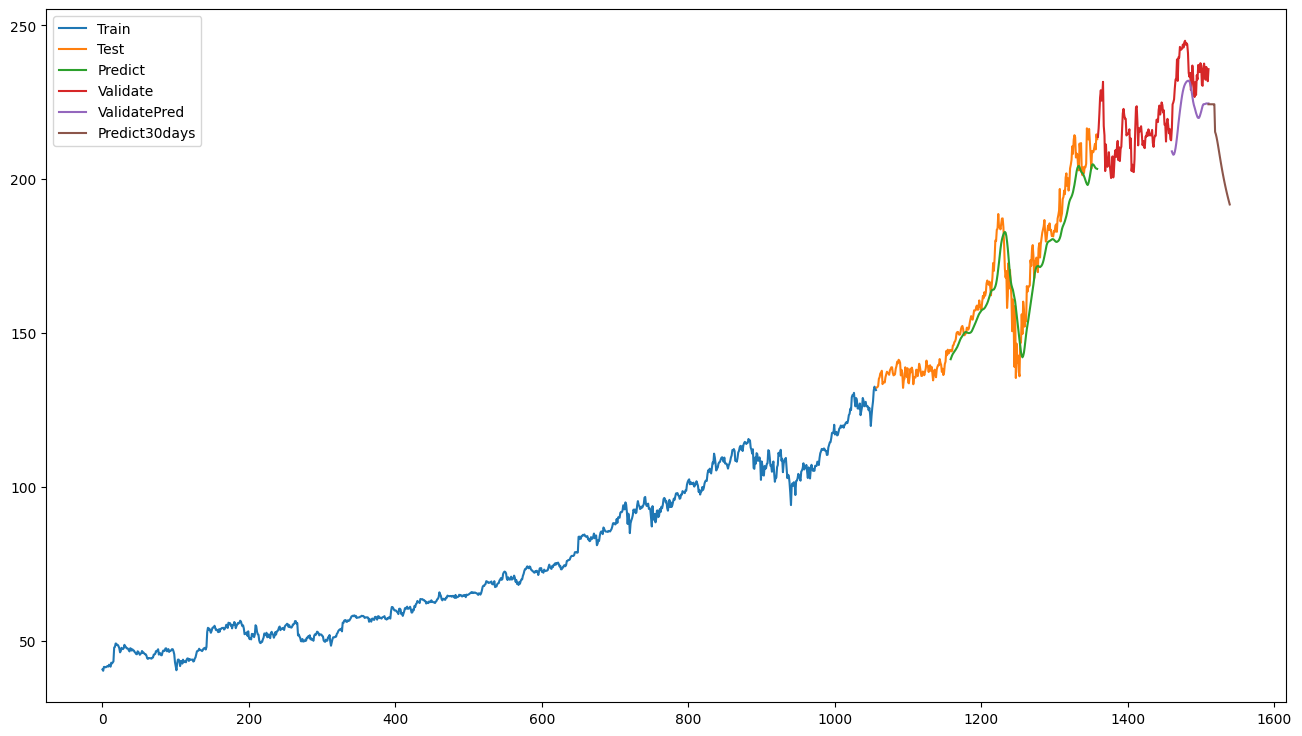

In [ ]:
# 14.Vẽ hình
plt.figure(figsize=(16,9))
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])

plt.show()